# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

# Environment Setup

In [0]:
!pip install pandas==0.25.1 pandas-profiling==2.3.0 scikit-learn==0.21.3 seaborn==0.9.0 kaggle==1.5.5 lightgbm
!mkdir -p /root/.kaggle

In [0]:
import io, os
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

done = False
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
request = drive_service.files().get_media(fileId=results['files'][0]['id'])
downloader = MediaIoBaseDownload(io.FileIO(filename, 'wb'), request)

while not done:
    status, done = downloader.next_chunk()
    print("Download {}%.".format(int(status.progress() * 100)))

os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


# Dependencies

In [0]:
import math
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn import preprocessing
from lightgbm import LGBMRegressor

# Data Loading

In [138]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df['Split'] = 'Train'
test_df['Split'] = 'Test'

full_data = pd.concat([
    train_df.drop(['SalePrice'], axis=1, inplace=False),
    test_df
], sort=False).reset_index(drop=True)

full_data.head()

Id  MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition  Split
0   1          60       RL         65.0  ...    2008       WD        Normal  Train
1   2          20       RL         80.0  ...    2007       WD        Normal  Train
2   3          60       RL         68.0  ...    2008       WD        Normal  Train
3   4          70       RL         60.0  ...    2006       WD       Abnorml  Train
4   5          60       RL         84.0  ...    2008       WD        Normal  Train

[5 rows x 81 columns]

# Overview

In [0]:
# profile = pandas_profiling.ProfileReport(full_data)
# profile.to_file('profile.html')

In [0]:
CONTINUOUS = 'continuous'
DISCRETE = 'discrete'
NOMINAL = 'nominal'
ORDINAL = 'ordinal'

variables = [
    {'name': 'MSSubClass', 'type': NOMINAL},
    {'name': 'MSZoning', 'type': NOMINAL}, # many values very uncommon
    {'name': 'LotFrontage', 'type': CONTINUOUS},
    {'name': 'LotArea', 'type': CONTINUOUS},
    {'name': 'Street', 'type': NOMINAL}, # only two values, can be binary
    {'name': 'Alley', 'type': NOMINAL}, # to many missing values
    {'name': 'LotShape', 'type': NOMINAL}, # 4 classes, most are REG or IR1
    {'name': 'LandContour', 'type': NOMINAL}, # 4 classes, most are flat
    {'name': 'Utilities', 'type': NOMINAL}, # one class has 99%, can be binary
    {'name': 'LotConfig', 'type': NOMINAL},
    {'name': 'LandSlope', 'type': NOMINAL}, # 95 are normal slope
    {'name': 'Neighborhood', 'type': NOMINAL},
    {'name': 'Condition1', 'type': NOMINAL},
    {'name': 'Condition2', 'type': NOMINAL}, # same value as Condition1, should merge with condition2
    {'name': 'BldgType', 'type': NOMINAL},
    {'name': 'HouseStyle', 'type': NOMINAL}, # should join uncommon classes
    {'name': 'OverallQual', 'type': DISCRETE},
    {'name': 'OverallCond', 'type': DISCRETE},
    {'name': 'YearBuilt', 'type': DISCRETE},
    {'name': 'YearRemodAdd', 'type': DISCRETE}, # Same as construction date if no remodeling or additions
    {'name': 'RoofStyle', 'type': NOMINAL}, # Join uncommon classes
    {'name': 'RoofMatl', 'type': NOMINAL}, # Maybe useless as 98 are same class
    {'name': 'Exterior1st', 'type': NOMINAL},
    {'name': 'Exterior2nd', 'type': NOMINAL}, # Same as 1st, merge with Exterion 1st
    {'name': 'MasVnrType', 'type': NOMINAL}, # One of class is none
    {'name': 'MasVnrArea', 'type': CONTINUOUS},
    {'name': 'ExterQual', 'type': ORDINAL}, # map to discrete
    {'name': 'ExterCond', 'type': ORDINAL}, # map to discrete
    {'name': 'Foundation', 'type': NOMINAL},
    {'name': 'BsmtQual', 'type': ORDINAL}, # the NA means no basement
    {'name': 'BsmtCond', 'type': ORDINAL}, # the NA means no basement, create "has_basement" feature
    {'name': 'BsmtExposure', 'type': ORDINAL},
    {'name': 'BsmtFinType1', 'type': ORDINAL},
    {'name': 'BsmtFinSF1', 'type': CONTINUOUS},
    {'name': 'BsmtFinType2', 'type': ORDINAL},
    {'name': 'BsmtFinSF2', 'type': CONTINUOUS},
    {'name': 'BsmtUnfSF', 'type': CONTINUOUS},
    {'name': 'TotalBsmtSF', 'type': CONTINUOUS},
    {'name': 'Heating', 'type': NOMINAL}, # 98 same class
    {'name': 'HeatingQC', 'type': ORDINAL},
    {'name': 'CentralAir', 'type': NOMINAL}, # Binary
    {'name': 'Electrical', 'type': NOMINAL},
    {'name': '1stFlrSF', 'type': CONTINUOUS},
    {'name': '2ndFlrSF', 'type': CONTINUOUS}, # empty when no floor, create "has_2_floor"
    {'name': 'LowQualFinSF', 'type': CONTINUOUS}, # 98% are zeros
    {'name': 'GrLivArea', 'type': CONTINUOUS}, # Relative to 1stFlrSF
    {'name': 'BsmtFullBath', 'type': DISCRETE},
    {'name': 'BsmtHalfBath', 'type': DISCRETE},
    {'name': 'FullBath', 'type': DISCRETE},
    {'name': 'HalfBath', 'type': DISCRETE},
    {'name': 'KitchenQual', 'type': ORDINAL},
    {'name': 'TotRmsAbvGrd', 'type': DISCRETE}, # relative to others rooms variables
    {'name': 'Functional', 'type': ORDINAL},
    {'name': 'Fireplaces', 'type': DISCRETE},
    {'name': 'FireplaceQu', 'type': ORDINAL},
    {'name': 'GarageType', 'type': NOMINAL}, # create has_garage
    {'name': 'GarageYrBlt', 'type': DISCRETE}, # Create garage_age
    {'name': 'GarageFinish', 'type': ORDINAL},
    {'name': 'GarageCars', 'type': DISCRETE},
    {'name': 'GarageArea', 'type': CONTINUOUS},
    {'name': 'GarageQual', 'type': ORDINAL},
    {'name': 'GarageCond', 'type': ORDINAL}, # related to garage qual
    {'name': 'PavedDrive', 'type': ORDINAL},
    {'name': 'WoodDeckSF', 'type': CONTINUOUS}, # create has_wood_deck
    {'name': 'OpenPorchSF', 'type': CONTINUOUS}, # create has_porch
    {'name': 'EnclosedPorch', 'type': CONTINUOUS}, # create has_EnclosedPorch
    {'name': '3SsnPorch', 'type': CONTINUOUS}, # create has_3SsnPorch
    {'name': 'ScreenPorch', 'type': CONTINUOUS}, # create has_ScreenPorch
    {'name': 'PoolArea', 'type': CONTINUOUS}, # create has_pool
    {'name': 'PoolQC', 'type': ORDINAL},
    {'name': 'Fence', 'type': NOMINAL}, # create has_Fence
    {'name': 'MiscFeature', 'type': NOMINAL}, # many empties, create has_shed or drop
    {'name': 'MiscVal', 'type': CONTINUOUS},
    {'name': 'MoSold', 'type': DISCRETE}, # maybe ignore
    {'name': 'YrSold', 'type': DISCRETE}, # ignore
    {'name': 'SaleType', 'type': NOMINAL},
    {'name': 'SaleCondition', 'type': NOMINAL},
]

continuous_variables = [x['name'] for x in variables if x['type'] == CONTINUOUS]
discrete_variables = [x['name'] for x in variables if x['type'] == DISCRETE]
nominal_variables = [x['name'] for x in variables if x['type'] == NOMINAL]
ordinal_variables = [x['name'] for x in variables if x['type'] == ORDINAL]
numerical_variables = continuous_variables + discrete_variables
categorical_variables = ordinal_variables + nominal_variables

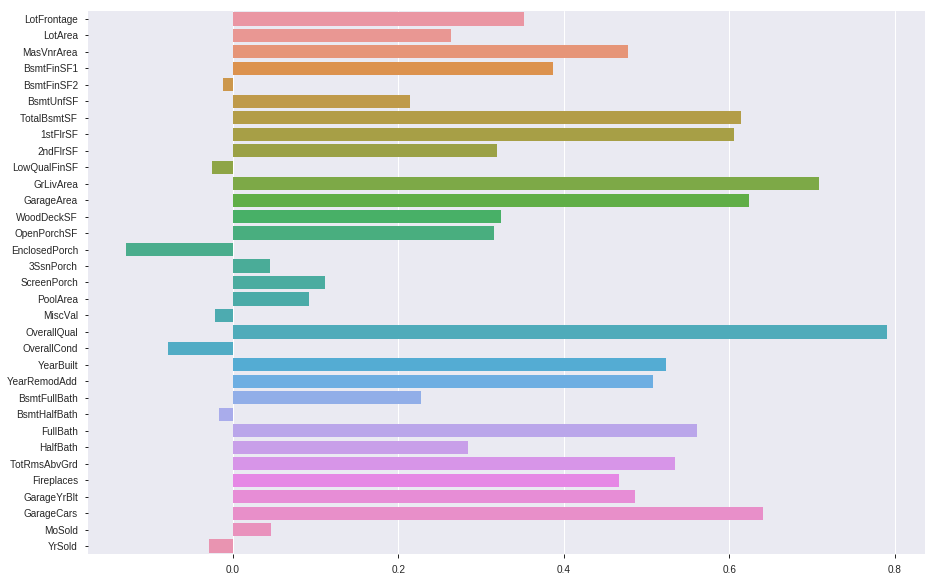

In [141]:
numerical_correlations = train_df[numerical_variables].apply(lambda x: x.corr(train_df['SalePrice']))

plt.figure(figsize=(15,10))
sns.barplot(y=numerical_correlations.index, x=numerical_correlations)
plt.show()

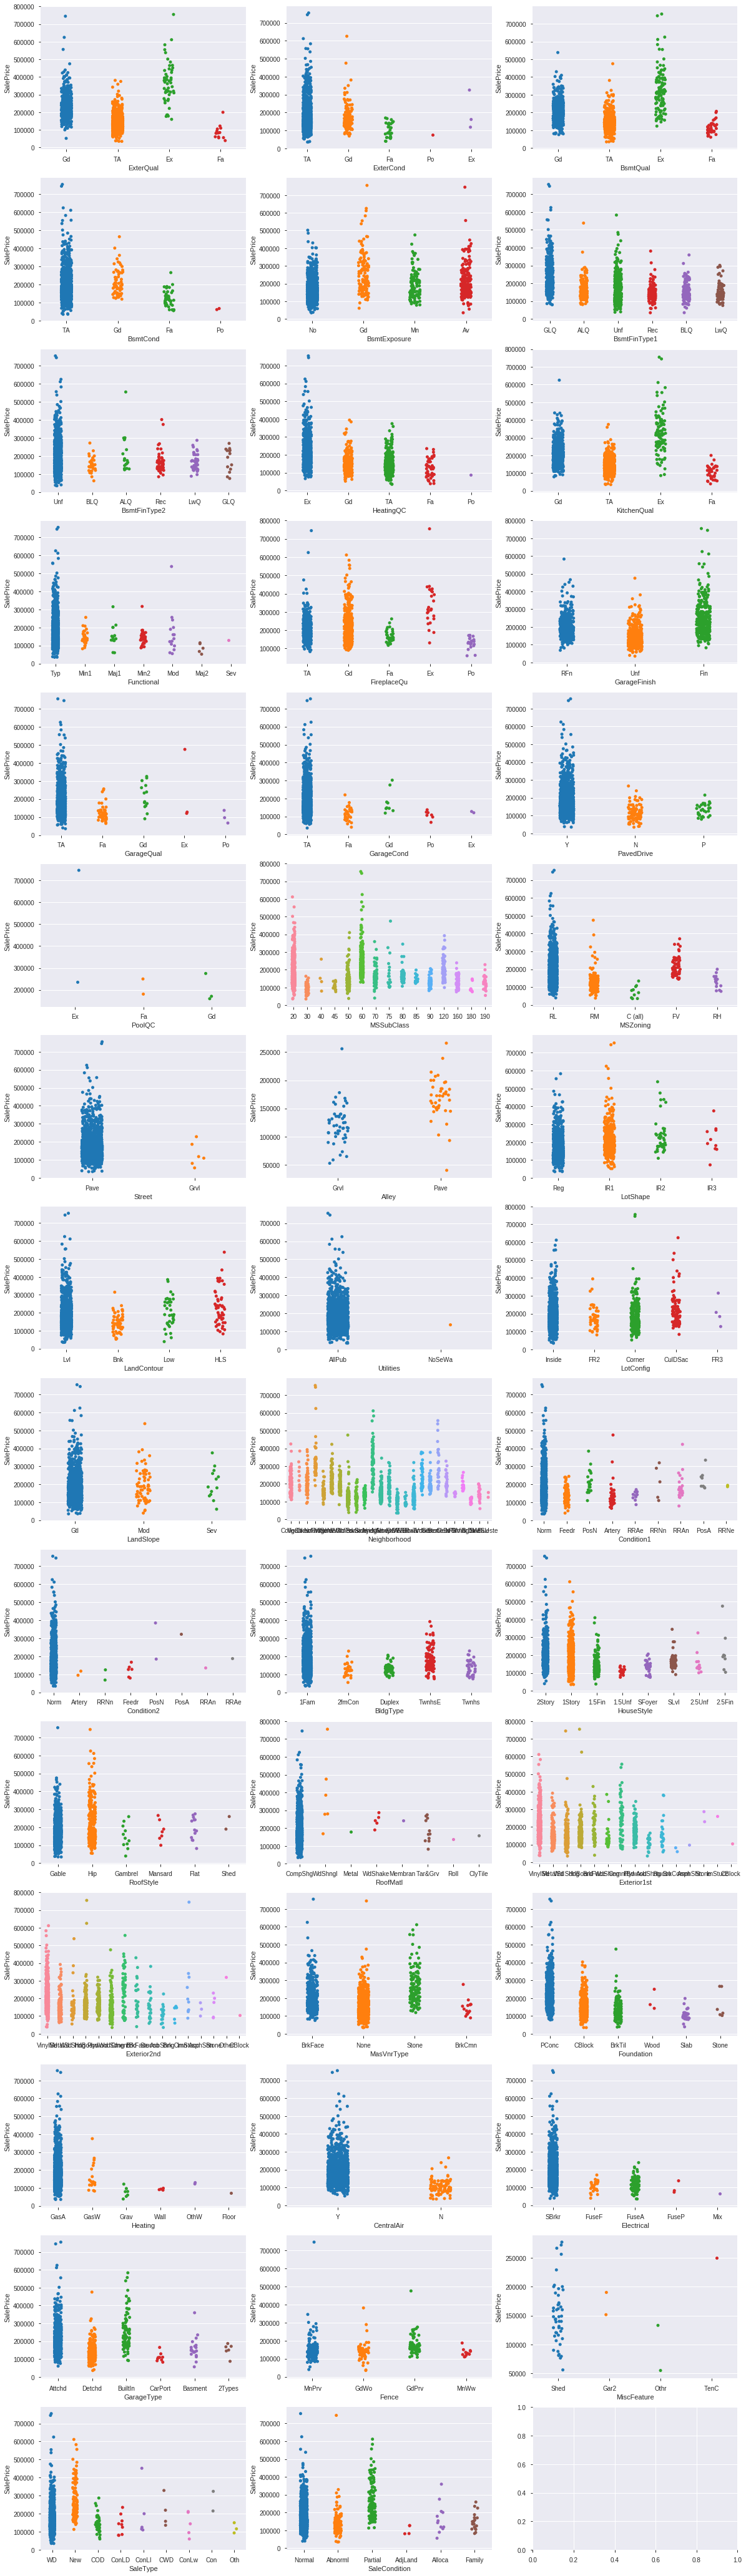

In [0]:
columns = 3
rows = math.ceil(len(categorical_variables) / columns)
fig, axes = plt.subplots(rows, columns, figsize=(20, 5 * rows))

for i, variable in enumerate(categorical_variables):
    sns.stripplot(x=variable, y='SalePrice', data=train_df, ax=axes[math.floor(i / columns)][i % columns])

fig.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


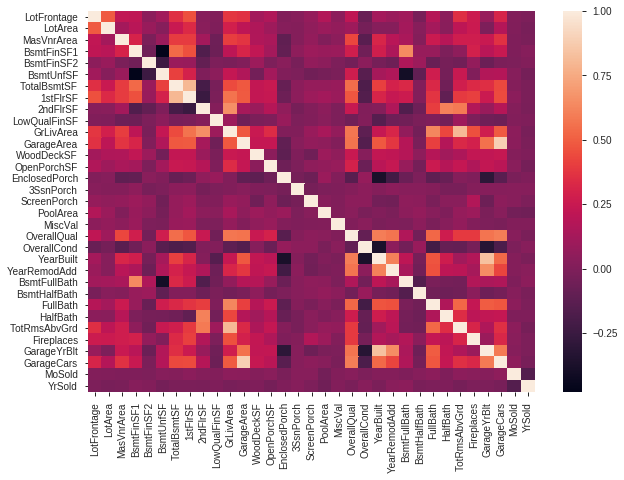

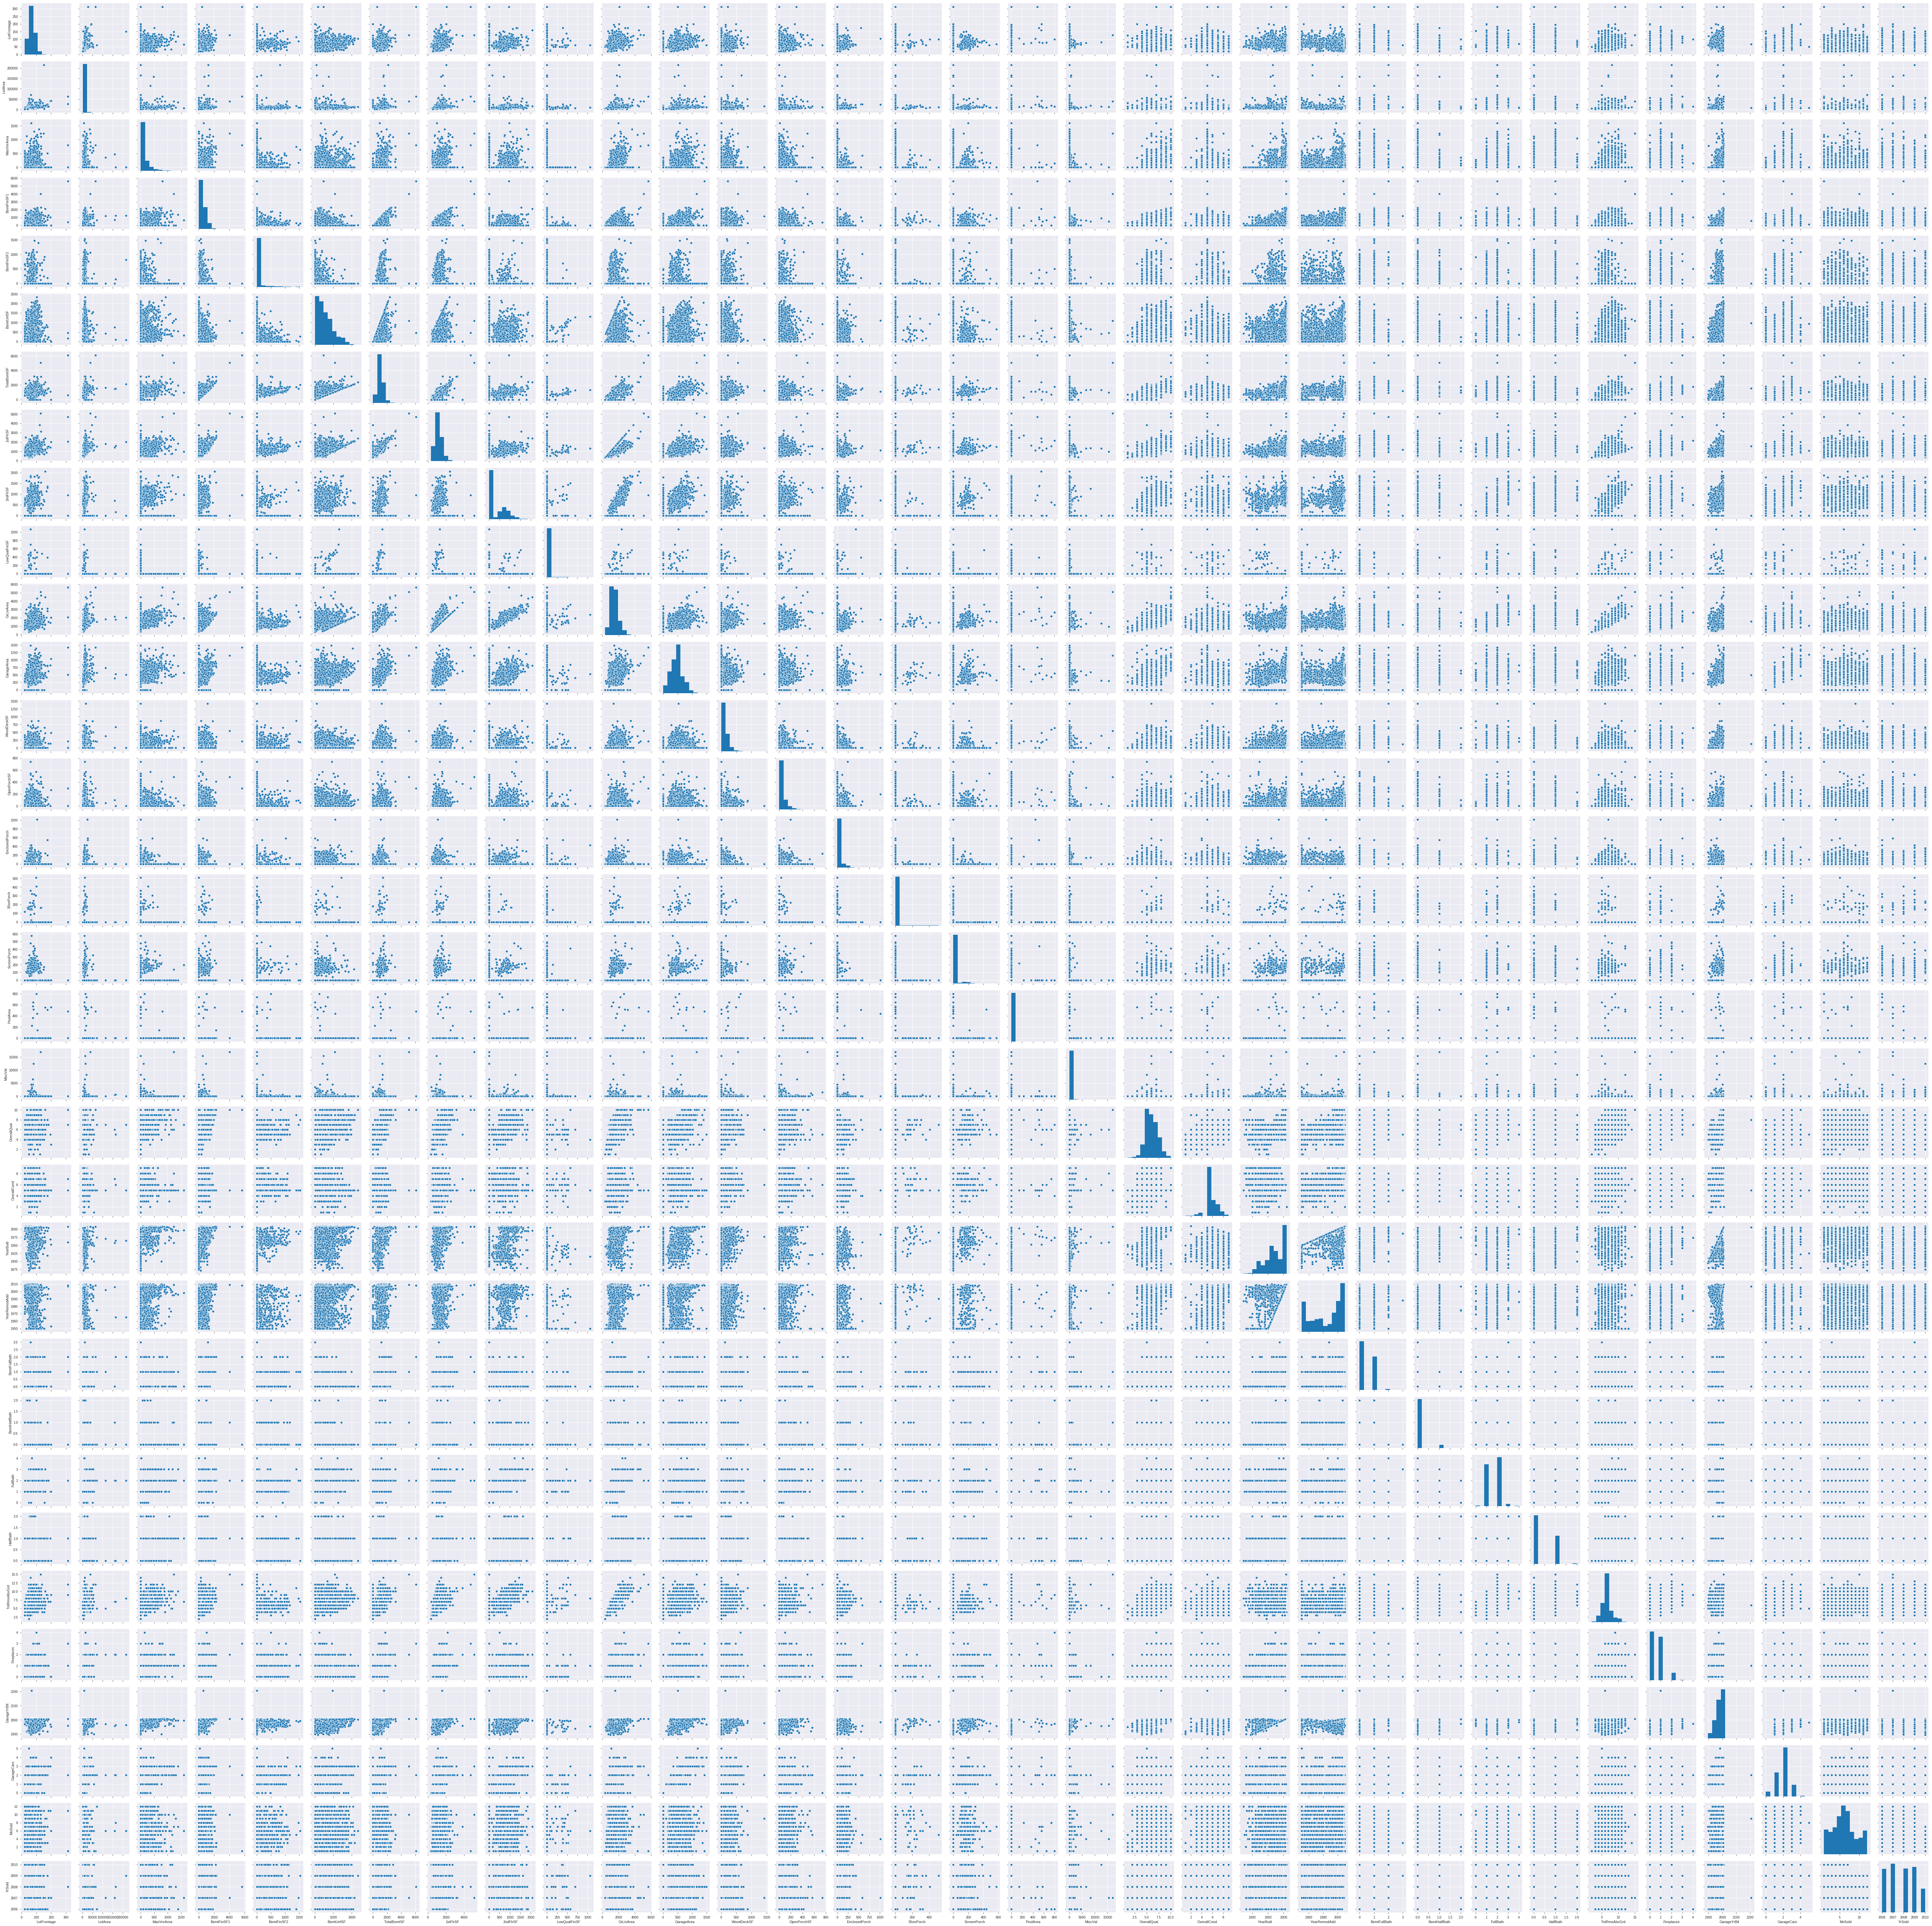

In [0]:
plt.figure(figsize=(10, 7))
sns.heatmap(full_data[numerical_variables].corr())
sns.pairplot(full_data[numerical_variables])
plt.show()

# Iteration 1: Baseline

In [145]:
top_correlations = numerical_correlations.nlargest(10)

print('Variables: {}'.format(','.join(top_correlations.index)))

X = train_df[top_correlations.index]
X = (X-X.min())/(X.max()-X.min())
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

regressor = RandomForestRegressor(random_state=1, n_estimators=100)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

iterations = [
    {
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'score': np.sqrt(mean_squared_log_error(y_test, y_pred)),
        'name': 'baseline'
    }
]

def display_last_iteration():
    print('MAE: {:0.2f}, RMSE: {:0.2f}, SCORE: {:0.4f}'.format(iterations[-1]['mae'], iterations[-1]['rmse'], iterations[-1]['score']))

display_last_iteration()

Variables: OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
MAE: 18628.41, RMSE: 26891.43, SCORE: 0.1634


# Iteration 2: Imputation

In [195]:
def map_ordinal(df, column):
    mapping = {
        # Qual
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0,
        # Bstm
        # 'Gd': 4,
        'Av': 3,
        'Mn': 2,
        'No': 1,
        # BsmtFinType
		'GLQ': 6,
		'ALQ': 5,
		'BLQ': 4,
		'Rec': 3,
		'LwQ': 2,
		'Unf': 1,
        # Functional
		'Typ': 8,
		'Min1': 7,
		'Min2': 6,
		'Mod': 5,
		'Maj1': 4,
		'Maj2': 3,
		'Sev': 2,
		'Sal': 1,
        # GarageFinish
		'Fin': 3,
		'RFn': 2,
		'Unf': 1,
        # Pavement
        'Y': 3,
        'P': 2,
        'N': 1,
        'NO': 0,
    }
    df[column + 'AsOrdinal'] = df[column].map(mapping)
    if df[column + 'AsOrdinal'].isnull().any():
        display(df[df[column + 'AsOrdinal'].isnull()][column].head())
        raise Exception('Cant map all fields of column {}'.format(column))
    return df

def map_nominal(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    df[dummies.columns] = dummies


full_data['BsmtQual'].fillna('TA', inplace=True)
full_data['BsmtCond'].fillna('TA', inplace=True)
full_data['BsmtExposure'].fillna('NO', inplace=True)
full_data['BsmtFinType1'].fillna('Unf', inplace=True)
full_data['BsmtFinType2'].fillna('Unf', inplace=True)
full_data['FireplaceQu'].fillna('NA', inplace=True)
full_data['GarageFinish'].fillna('Unf', inplace=True)
full_data['GarageQual'].fillna('TA', inplace=True)
full_data['GarageCond'].fillna('TA', inplace=True)
full_data['PoolQC'].fillna('NA', inplace=True)
full_data['Alley'].fillna('Pave', inplace=True)
full_data['MasVnrType'].fillna('None', inplace=True)
full_data['Electrical'].fillna('SBrkr', inplace=True)
full_data['GarageType'].fillna('Attchd', inplace=True)
full_data['Fence'].fillna('NA', inplace=True)
full_data['MiscFeature'].fillna('NA', inplace=True)
full_data['KitchenQual'].fillna('TA', inplace=True)
full_data['Functional'].fillna('Typ', inplace=True)
full_data['MSZoning'].fillna('RL', inplace=True)
full_data['Utilities'].fillna('AllPub', inplace=True)
full_data['Exterior1st'].fillna('NA', inplace=True)
full_data['Exterior2nd'].fillna('NA', inplace=True)
full_data['SaleType'].fillna('WD', inplace=True)

for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','Bathrooms','TotalArea']:
    full_data[column].fillna(full_data[column].mean(), inplace=True)

full_data.loc[full_data['GarageYrBlt'].isna(), 'GarageYrBlt'] = full_data['YearBuilt']

for variable in ordinal_variables:
    map_ordinal(full_data, variable)

for variable in nominal_variables:
    map_nominal(full_data, variable)

if len(full_data.columns[full_data.isna().any()]):
    raise Exception(str(full_data.columns[full_data.isna().any()]))

X = full_data.drop(categorical_variables + ['Id'], axis=1)\
    .loc[full_data['Split'] == 'Train']\
    .drop(['Split'], axis=1)

y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

regressor = RandomForestRegressor(random_state=1, n_estimators=100)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

iterations.append({
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'score': np.sqrt(mean_squared_log_error(y_test, y_pred)),
    'name': 'imputation'
})

display_last_iteration()

MAE: 16106.75, RMSE: 27077.44, SCORE: 0.1401


# Iteration 3: Feature Enginering

In [201]:
ignored_variables = categorical_variables + [
    'Id',
    'Split',
    'YearBuilt',
    'GarageYrBlt',
    'YearRemodAdd',
    'MiscFeature_NA',
]

full_data['Floors'] = 1
full_data.loc[full_data['2ndFlrSF'] > 0, 'Floors'] = 2
full_data['HasFireplaces'] = full_data['Fireplaces'] > 0
full_data['HasPool'] = full_data['PoolArea'] > 0
full_data['HasGarage'] = full_data['GarageArea'] > 0
full_data['Age'] = full_data['YrSold'] - full_data['YearBuilt']
full_data['GarageAge'] = full_data['YrSold'] - full_data['GarageYrBlt']
full_data['RemodAge'] = full_data['YrSold'] - full_data['YearRemodAdd']
full_data['Bathrooms'] = full_data['BsmtFullBath'] + full_data['BsmtHalfBath'] + full_data['FullBath'] + full_data['HalfBath']
full_data['PorchArea'] = full_data['OpenPorchSF'] + full_data['EnclosedPorch'] + full_data['3SsnPorch'] + full_data['ScreenPorch']
full_data['TotalArea'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF'] + full_data['GrLivArea']

full_data['HasBasement'] = False
full_data.loc[full_data['BsmtCond'] != 'NA', 'HasBasement'] = True

full_data['IsNew'] = False
full_data.loc[full_data['Age'] < 5, 'IsNew'] = True

full_data['IsRemodeled'] = False
full_data.loc[full_data['YearBuilt'] < full_data['YearRemodAdd'], 'IsRemodeled'] = True

X = full_data.loc[full_data['Split'] == 'Train']\
    .drop(ignored_variables, axis=1)

y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

regressor = RandomForestRegressor(random_state=1, n_estimators=100)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

iterations.append({
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'score': np.sqrt(mean_squared_log_error(y_test, y_pred)),
    'name': 'feature enginering'
})

display_last_iteration()

X.head()

MAE: 16425.31, RMSE: 27867.19, SCORE: 0.1409


LotFrontage  LotArea  OverallQual  ...  IsNew  IsRemodeled  HasGarage
0         65.0     8450            7  ...  False        False       True
1         80.0     9600            6  ...  False        False       True
2         68.0    11250            7  ...  False         True       True
3         60.0     9550            7  ...  False         True       True
4         84.0    14260            8  ...  False        False       True

[5 rows x 259 columns]

# Iteration 4: Model Tuning

In [202]:
X = full_data.loc[full_data['Split'] == 'Train']\
    .drop(ignored_variables, axis=1)

y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

params = {
    'num_leaves': [16, 32, 64],
    'n_estimators': [50, 100, 150],
    'subsample_for_bin': [100, 1000, 2000],
    'reg_alpha': [1, 1.2],
    'reg_lambda': [1, 1.2, 1.4],
}

xgb = LGBMRegressor(random_state=1, nthread=-1, cv=5)
xgb.fit(X_train, y_train)

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

regressor = grid.best_estimator_
y_pred = regressor.predict(X_test)

iterations.append({
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'score': np.sqrt(mean_squared_log_error(y_test, y_pred)),
    'name': 'model tuning'
})

display_last_iteration()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


MAE: 15221.95, RMSE: 27535.02, SCORE: 0.1301


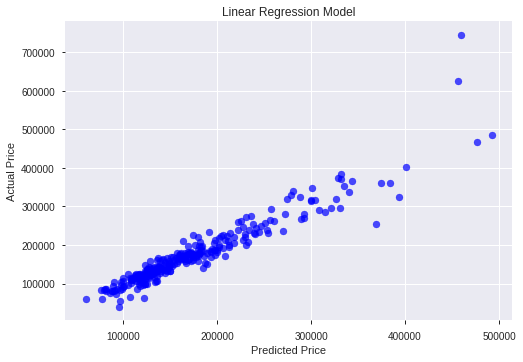

In [203]:
plt.scatter(y_pred, y_test, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

# Submission

In [206]:
test_data = full_data.loc[full_data['Split'] == 'Test']

X = test_data.drop(ignored_variables, axis=1)

y_pred = regressor.predict(X)

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_pred,
})

display(submission.head())

submission.to_csv('submission.csv', index=False)

Id      SalePrice
1460  1461  122109.073727
1461  1462  166592.478299
1462  1463  184009.448512
1463  1464  189395.779876
1464  1465  199931.724914

In [207]:
!kaggle competitions submit house-prices-advanced-regression-techniques -f submission.csv -m "1st trial"

100% 33.7k/33.7k [00:00<00:00, 130kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques